In [43]:
from mpi4py import MPI
import numpy as np
import pylab as plt

import uvtools
import pyuvdata
from pyuvdata import UVData
from pyuvsim import BeamList

from hera_sim.visibilities import ModelData
from hera_sim import Simulator
from hera_sim.beams import PolyBeam, PerturbedPolyBeam, ZernikeBeam

# import ultranest

try:
    import healpy
    import healvis
except:
    print("Unable to import healpy and/or healvis; diffuse mode unavailable")

from VisModel import utils
import time, copy, sys
from numba import jit
import astropy
from pyradiosky import SkyModel
from scipy.linalg import cholesky, expm, sqrtm, eig
from scipy.sparse.linalg import cg
from astropy.time import Time
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.special import jv
from scipy.fftpack import fft, fftshift

import warnings
import os

# Begin MPI
#if use_mpi:
#    comm = MPI.COMM_WORLD
#    myid = comm.Get_rank()
#else:
#    comm = None
#    myid = 0

Unable to import healpy and/or healvis; diffuse mode unavailable


In [2]:
def zernike(coeffs, x, y):
        """
        Zernike polynomials (up to degree 66) on the unit disc.
        This code was adapted from:
        https://gitlab.nrao.edu/pjaganna/zcpb/-/blob/master/zernikeAperture.py
        Parameters
        ----------
        coeffs : array_like
            Array of real coefficients of the Zernike polynomials, from 0..66.
        x, y : array_like
            Points on the unit disc.
        Returns
        -------
        zernike : array_like
            Values of the Zernike polynomial at the input x,y points.
        """
        # Coefficients
        assert len(coeffs) <= 66, "Max. number of coeffs is 66."
        c = np.zeros(66)
        c[: len(coeffs)] += coeffs

        # Precompute powers of x and y
        x2, x3, x4, x5, x6, x7, x8, x9, x10 = tuple(x ** idx for idx in range(2, 11))
        y2, y3, y4, y5, y6, y7, y8, y9, y10 = tuple(y ** idx for idx in range(2, 11))

        # Setting the equations for the Zernike polynomials
        # r = np.sqrt(powl(x,2) + powl(y,2))
        Z = {
            1: c[0] * np.ones(len(x)),  # m = 0    n = 0
            2: c[1] * x,  # m = -1   n = 1
            3: c[2] * y,  # m = 1    n = 1
            4: c[3] * 2 * x * y,  # m = -2   n = 2
            5: c[4] * (2 * x2 + 2 * y2 - 1),  # m = 0  n = 2
            6: c[5] * (-1 * x2 + y2),  # m = 2  n = 2
            7: c[6] * (-1 * x3 + 3 * x * y2),  # m = -3     n = 3
            8: c[7] * (-2 * x + 3 * (x3) + 3 * x * (y2)),  # m = -1   n = 3
            9: c[8] * (-2 * y + 3 * y3 + 3 * (x2) * y),  # m = 1    n = 3
            10: c[9] * (y3 - 3 * (x2) * y),  # m = 3 n =3
            11: c[10] * (-4 * (x3) * y + 4 * x * (y3)),  # m = -4    n = 4
            12: c[11] * (-6 * x * y + 8 * (x3) * y + 8 * x * (y3)),  # m = -2   n = 4
            13: c[12]
            * (
                1 - 6 * x2 - 6 * y2 + 6 * x4 + 12 * (x2) * (y2) + 6 * y4
            ),  # m = 0  n = 4
            14: c[13] * (3 * x2 - 3 * y2 - 4 * x4 + 4 * y4),  # m = 2    n = 4
            15: c[14] * (x4 - 6 * (x2) * (y2) + y4),  # m = 4   n = 4
            16: c[15] * (x5 - 10 * (x3) * y2 + 5 * x * (y4)),  # m = -5   n = 5
            17: c[16]
            * (
                4 * x3 - 12 * x * (y2) - 5 * x5 + 10 * (x3) * (y2) + 15 * x * y4
            ),  # m =-3     n = 5
            18: c[17]
            * (
                3 * x
                - 12 * x3
                - 12 * x * (y2)
                + 10 * x5
                + 20 * (x3) * (y2)
                + 10 * x * (y4)
            ),  # m= -1  n = 5
            19: c[18]
            * (
                3 * y
                - 12 * y3
                - 12 * y * (x2)
                + 10 * y5
                + 20 * (y3) * (x2)
                + 10 * y * (x4)
            ),  # m = 1  n = 5
            20: c[19]
            * (
                -4 * y3 + 12 * y * (x2) + 5 * y5 - 10 * (y3) * (x2) - 15 * y * x4
            ),  # m = 3   n = 5
            21: c[20] * (y5 - 10 * (y3) * x2 + 5 * y * (x4)),  # m = 5 n = 5
            22: c[21]
            * (6 * (x5) * y - 20 * (x3) * (y3) + 6 * x * (y5)),  # m = -6 n = 6
            23: c[22]
            * (
                20 * (x3) * y - 20 * x * (y3) - 24 * (x5) * y + 24 * x * (y5)
            ),  # m = -4   n = 6
            24: c[23]
            * (
                12 * x * y
                + 40 * (x3) * y
                - 40 * x * (y3)
                + 30 * (x5) * y
                + 60 * (x3) * (y3)
                - 30 * x * (y5)
            ),  # m = -2   n = 6
            25: c[24]
            * (
                -1
                + 12 * (x2)
                + 12 * (y2)
                - 30 * (x4)
                - 60 * (x2) * (y2)
                - 30 * (y4)
                + 20 * (x6)
                + 60 * (x4) * y2
                + 60 * (x2) * (y4)
                + 20 * (y6)
            ),  # m = 0   n = 6
            26: c[25]
            * (
                -6 * (x2)
                + 6 * (y2)
                + 20 * (x4)
                - 20 * (y4)
                - 15 * (x6)
                - 15 * (x4) * (y2)
                + 15 * (x2) * (y4)
                + 15 * (y6)
            ),  # m = 2   n = 6
            27: c[26]
            * (
                -5 * (x4)
                + 30 * (x2) * (y2)
                - 5 * (y4)
                + 6 * (x6)
                - 30 * (x4) * y2
                - 30 * (x2) * (y4)
                + 6 * (y6)
            ),  # m = 4    n = 6
            28: c[27]
            * (-1 * (x6) + 15 * (x4) * (y2) - 15 * (x2) * (y4) + y6),  # m = 6   n = 6
            29: c[28]
            * (
                -1 * (x7) + 21 * (x5) * (y2) - 35 * (x3) * (y4) + 7 * x * (y6)
            ),  # m = -7    n = 7
            30: c[29]
            * (
                -6 * (x5)
                + 60 * (x3) * (y2)
                - 30 * x * (y4)
                + 7 * x7
                - 63 * (x5) * (y2)
                - 35 * (x3) * (y4)
                + 35 * x * (y6)
            ),  # m = -5    n = 7
            31: c[30]
            * (
                -10 * (x3)
                + 30 * x * (y2)
                + 30 * x5
                - 60 * (x3) * (y2)
                - 90 * x * (y4)
                - 21 * x7
                + 21 * (x5) * (y2)
                + 105 * (x3) * (y4)
                + 63 * x * (y6)
            ),  # m =-3       n = 7
            32: c[31]
            * (
                -4 * x
                + 30 * x3
                + 30 * x * (y2)
                - 60 * (x5)
                - 120 * (x3) * (y2)
                - 60 * x * (y4)
                + 35 * x7
                + 105 * (x5) * (y2)
                + 105 * (x3) * (y4)
                + 35 * x * (y6)
            ),  # m = -1  n = 7
            33: c[32]
            * (
                -4 * y
                + 30 * y3
                + 30 * y * (x2)
                - 60 * (y5)
                - 120 * (y3) * (x2)
                - 60 * y * (x4)
                + 35 * y7
                + 105 * (y5) * (x2)
                + 105 * (y3) * (x4)
                + 35 * y * (x6)
            ),  # m = 1   n = 7
            34: c[33]
            * (
                10 * (y3)
                - 30 * y * (x2)
                - 30 * y5
                + 60 * (y3) * (x2)
                + 90 * y * (x4)
                + 21 * y7
                - 21 * (y5) * (x2)
                - 105 * (y3) * (x4)
                - 63 * y * (x6)
            ),  # m =3     n = 7
            35: c[34]
            * (
                -6 * (y5)
                + 60 * (y3) * (x2)
                - 30 * y * (x4)
                + 7 * y7
                - 63 * (y5) * (x2)
                - 35 * (y3) * (x4)
                + 35 * y * (x6)
            ),  # m = 5  n = 7
            36: c[35]
            * (y7 - 21 * (y5) * (x2) + 35 * (y3) * (x4) - 7 * y * (x6)),  # m = 7  n = 7
            37: c[36]
            * (
                -8 * (x7) * y + 56 * (x5) * (y3) - 56 * (x3) * (y5) + 8 * x * (y7)
            ),  # m = -8  n = 8
            38: c[37]
            * (
                -42 * (x5) * y
                + 140 * (x3) * (y3)
                - 42 * x * (y5)
                + 48 * (x7) * y
                - 112 * (x5) * (y3)
                - 112 * (x3) * (y5)
                + 48 * x * (y7)
            ),  # m = -6  n = 8
            39: c[38]
            * (
                -60 * (x3) * y
                + 60 * x * (y3)
                + 168 * (x5) * y
                - 168 * x * (y5)
                - 112 * (x7) * y
                - 112 * (x5) * (y3)
                + 112 * (x3) * (y5)
                + 112 * x * (y7)
            ),  # m = -4   n = 8
            40: c[39]
            * (
                -20 * x * y
                + 120 * (x3) * y
                + 120 * x * (y3)
                - 210 * (x5) * y
                - 420 * (x3) * (y3)
                - 210 * x * (y5)
                - 112 * (x7) * y
                + 336 * (x5) * (y3)
                + 336 * (x3) * (y5)
                + 112 * x * (y7)
            ),  # m = -2   n = 8
            41: c[40]
            * (
                1
                - 20 * x2
                - 20 * y2
                + 90 * x4
                + 180 * (x2) * (y2)
                + 90 * y4
                - 140 * x6
                - 420 * (x4) * (y2)
                - 420 * (x2) * (y4)
                - 140 * (y6)
                + 70 * x8
                + 280 * (x6) * (y2)
                + 420 * (x4) * (y4)
                + 280 * (x2) * (y6)
                + 70 * y8
            ),  # m = 0    n = 8
            42: c[41]
            * (
                10 * x2
                - 10 * y2
                - 60 * x4
                + 105 * (x4) * (y2)
                - 105 * (x2) * (y4)
                + 60 * y4
                + 105 * x6
                - 105 * y6
                - 56 * x8
                - 112 * (x6) * (y2)
                + 112 * (x2) * (y6)
                + 56 * y8
            ),  # m = 2  n = 8
            43: c[42]
            * (
                15 * x4
                - 90 * (x2) * (y2)
                + 15 * y4
                - 42 * x6
                + 210 * (x4) * (y2)
                + 210 * (x2) * (y4)
                - 42 * y6
                + 28 * x8
                - 112 * (x6) * (y2)
                - 280 * (x4) * (y4)
                - 112 * (x2) * (y6)
                + 28 * y8
            ),  # m = 4     n = 8
            44: c[43]
            * (
                7 * x6
                - 105 * (x4) * (y2)
                + 105 * (x2) * (y4)
                - 7 * y6
                - 8 * x8
                + 112 * (x6) * (y2)
                - 112 * (x2) * (y6)
                + 8 * y8
            ),  # m = 6    n = 8
            45: c[44]
            * (
                x8 - 28 * (x6) * (y2) + 70 * (x4) * (y4) - 28 * (x2) * (y6) + y8
            ),  # m = 8     n = 9
            46: c[45]
            * (
                x9
                - 36 * (x7) * (y2)
                + 126 * (x5) * (y4)
                - 84 * (x3) * (y6)
                + 9 * x * (y8)
            ),  # m = -9     n = 9
            47: c[46]
            * (
                8 * x7
                - 168 * (x5) * (y2)
                + 280 * (x3) * (y4)
                - 56 * x * (y6)
                - 9 * x9
                + 180 * (x7) * (y2)
                - 126 * (x5) * (y4)
                - 252 * (x3) * (y6)
                + 63 * x * (y8)
            ),  # m = -7    n = 9
            48: c[47]
            * (
                21 * x5
                - 210 * (x3) * (y2)
                + 105 * x * (y4)
                - 56 * x7
                + 504 * (x5) * (y2)
                + 280 * (x3) * (y4)
                - 280 * x * (y6)
                + 36 * x9
                - 288 * (x7) * (y2)
                - 504 * (x5) * (y4)
                + 180 * x * (y8)
            ),  # m = -5    n = 9
            49: c[48]
            * (
                20 * x3
                - 60 * x * (y2)
                - 105 * x5
                + 210 * (x3) * (y2)
                + 315 * x * (y4)
                + 168 * x7
                - 168 * (x5) * (y2)
                - 840 * (x3) * (y4)
                - 504 * x * (y6)
                - 84 * x9
                + 504 * (x5) * (y4)
                + 672 * (x3) * (y6)
                + 252 * x * (y8)
            ),  # m = -3  n = 9
            50: c[49]
            * (
                5 * x
                - 60 * x3
                - 60 * x * (y2)
                + 210 * x5
                + 420 * (x3) * (y2)
                + 210 * x * (y4)
                - 280 * x7
                - 840 * (x5) * (y2)
                - 840 * (x3) * (y4)
                - 280 * x * (y6)
                + 126 * x9
                + 504 * (x7) * (y2)
                + 756 * (x5) * (y4)
                + 504 * (x3) * (y6)
                + 126 * x * (y8)
            ),  # m = -1   n = 9
            51: c[50]
            * (
                5 * y
                - 60 * y3
                - 60 * y * (x2)
                + 210 * y5
                + 420 * (y3) * (x2)
                + 210 * y * (x4)
                - 280 * y7
                - 840 * (y5) * (x2)
                - 840 * (y3) * (x4)
                - 280 * y * (x6)
                + 126 * y9
                + 504 * (y7) * (x2)
                + 756 * (y5) * (x4)
                + 504 * (y3) * (x6)
                + 126 * y * (x8)
            ),  # m = -1   n = 9
            52: c[51]
            * (
                -20 * y3
                + 60 * y * (x2)
                + 105 * y5
                - 210 * (y3) * (x2)
                - 315 * y * (x4)
                - 168 * y7
                + 168 * (y5) * (x2)
                + 840 * (y3) * (x4)
                + 504 * y * (x6)
                + 84 * y9
                - 504 * (y5) * (x4)
                - 672 * (y3) * (x6)
                - 252 * y * (x8)
            ),  # m = 3  n = 9
            53: c[52]
            * (
                21 * y5
                - 210 * (y3) * (x2)
                + 105 * y * (x4)
                - 56 * y7
                + 504 * (y5) * (x2)
                + 280 * (y3) * (x4)
                - 280 * y * (x6)
                + 36 * y9
                - 288 * (y7) * (x2)
                - 504 * (y5) * (x4)
                + 180 * y * (x8)
            ),  # m = 5     n = 9
            54: c[53]
            * (
                -8 * y7
                + 168 * (y5) * (x2)
                - 280 * (y3) * (x4)
                + 56 * y * (x6)
                + 9 * y9
                - 180 * (y7) * (x2)
                + 126 * (y5) * (x4)
                - 252 * (y3) * (x6)
                - 63 * y * (x8)
            ),  # m = 7     n = 9
            55: c[54]
            * (
                y9
                - 36 * (y7) * (x2)
                + 126 * (y5) * (x4)
                - 84 * (y3) * (x6)
                + 9 * y * (x8)
            ),  # m = 9       n = 9
            56: c[55]
            * (
                10 * (x9) * y
                - 120 * (x7) * (y3)
                + 252 * (x5) * (y5)
                - 120 * (x3) * (y7)
                + 10 * x * (y9)
            ),  # m = -10   n = 10
            57: c[56]
            * (
                72 * (x7) * y
                - 504 * (x5) * (y3)
                + 504 * (x3) * (y5)
                - 72 * x * (y7)
                - 80 * (x9) * y
                + 480 * (x7) * (y3)
                - 480 * (x3) * (y7)
                + 80 * x * (y9)
            ),  # m = -8    n = 10
            58: c[57]
            * (
                270 * (x9) * y
                - 360 * (x7) * (y3)
                - 1260 * (x5) * (y5)
                - 360 * (x3) * (y7)
                + 270 * x * (y9)
                - 432 * (x7) * y
                + 1008 * (x5) * (y3)
                + 1008 * (x3) * (y5)
                - 432 * x * (y7)
                + 168 * (x5) * y
                - 560 * (x3) * (y3)
                + 168 * x * (y5)
            ),  # m = -6   n = 10
            59: c[58]
            * (
                140 * (x3) * y
                - 140 * x * (y3)
                - 672 * (x5) * y
                + 672 * x * (y5)
                + 1008 * (x7) * y
                + 1008 * (x5) * (y3)
                - 1008 * (x3) * (y5)
                - 1008 * x * (y7)
                - 480 * (x9) * y
                - 960 * (x7) * (y3)
                + 960 * (x3) * (y7)
                + 480 * x * (y9)
            ),  # m = -4   n = 10
            60: c[59]
            * (
                30 * x * y
                - 280 * (x3) * y
                - 280 * x * (y3)
                + 840 * (x5) * y
                + 1680 * (x3) * (y3)
                + 840 * x * (y5)
                - 1008 * (x7) * y
                - 3024 * (x5) * (y3)
                - 3024 * (x3) * (y5)
                - 1008 * x * (y7)
                + 420 * (x9) * y
                + 1680 * (x7) * (y3)
                + 2520 * (x5) * (y5)
                + 1680 * (x3) * (y7)
                + 420 * x * (y9)
            ),  # m = -2   n = 10
            61: c[60]
            * (
                -1
                + 30 * x2
                + 30 * y2
                - 210 * x4
                - 420 * (x2) * (y2)
                - 210 * y4
                + 560 * x6
                + 1680 * (x4) * (y2)
                + 1680 * (x2) * (y4)
                + 560 * y6
                - 630 * x8
                - 2520 * (x6) * (y2)
                - 3780 * (x4) * (y4)
                - 2520 * (x2) * (y6)
                - 630 * y8
                + 252 * x10
                + 1260 * (x8) * (y2)
                + 2520 * (x6) * (y4)
                + 2520 * (x4) * (y6)
                + 1260 * (x2) * (y8)
                + 252 * y10
            ),  # m = 0    n = 10
            62: c[61]
            * (
                -15 * x2
                + 15 * y2
                + 140 * x4
                - 140 * y4
                - 420 * x6
                - 420 * (x4) * (y2)
                + 420 * (x2) * (y4)
                + 420 * y6
                + 504 * x8
                + 1008 * (x6) * (y2)
                - 1008 * (x2) * (y6)
                - 504 * y8
                - 210 * x10
                - 630 * (x8) * (y2)
                - 420 * (x6) * (y4)
                + 420 * (x4) * (y6)
                + 630 * (x2) * (y8)
                + 210 * y10
            ),  # m = 2  n = 10
            63: c[62]
            * (
                -35 * x4
                + 210 * (x2) * (y2)
                - 35 * y4
                + 168 * x6
                - 840 * (x4) * (y2)
                - 840 * (x2) * (y4)
                + 168 * y6
                - 252 * x8
                + 1008 * (x6) * (y2)
                + 2520 * (x4) * (y4)
                + 1008 * (x2) * (y6)
                - 252 * (y8)
                + 120 * x10
                - 360 * (x8) * (y2)
                - 1680 * (x6) * (y4)
                - 1680 * (x4) * (y6)
                - 360 * (x2) * (y8)
                + 120 * y10
            ),  # m = 4     n = 10
            64: c[63]
            * (
                -28 * x6
                + 420 * (x4) * (y2)
                - 420 * (x2) * (y4)
                + 28 * y6
                + 72 * x8
                - 1008 * (x6) * (y2)
                + 1008 * (x2) * (y6)
                - 72 * y8
                - 45 * x10
                + 585 * (x8) * (y2)
                + 630 * (x6) * (y4)
                - 630 * (x4) * (y6)
                - 585 * (x2) * (y8)
                + 45 * y10
            ),  # m = 6    n = 10
            65: c[64]
            * (
                -9 * x8
                + 252 * (x6) * (y2)
                - 630 * (x4) * (y4)
                + 252 * (x2) * (y6)
                - 9 * y8
                + 10 * x10
                - 270 * (x8) * (y2)
                + 420 * (x6) * (y4)
                + 420 * (x4) * (y6)
                - 270 * (x2) * (y8)
                + 10 * y10
            ),  # m = 8    n = 10
            66: c[65]
            * (
                -1 * x10
                + 45 * (x8) * (y2)
                - 210 * (x6) * (y4)
                + 210 * (x4) * (y6)
                - 45 * (x2) * (y8)
                + y10
            ),  # m = 10   n = 10
        }
        return Z
    


In [3]:
c = 3e-8

class beam_sampler:
    
    def __init__(self, skymodel, uvd, initial_zernike_coeffs,
                 noise_cov, prior_mean_block=None,
                 prior_cov_block=None):
        if uvd.Nfreqs > 1:
            msg = "Multifrequency sampling not implemented yet. Please trim UVData object to one frequency."
            raise ValueError(msg)
        if uvd.Ntimes > 1:
            msg = "Multitime sampling not implemented yet. Please trim UVData object to one time."
            raise ValueError(msg)
        
        self.skymodel = skymodel
        self.uvd = uvd
        self.noise_cov = noise_cov
        self.noise_cov_inv = 1 / self.noise_cov
        
        time = Time(self.uvd.time_array[0], format='jd')
        lat, lon, alt = self.uvd.telescope_location_lat_lon_alt
        earth_loc = astropy.coordinates.EarthLocation(lat=lat, lon=lon, height=alt)
        
        self.skymodel.update_positions(time,
                                       earth_loc)
        
        #self.rhos = np.sqrt(np.sum(self.skymodel.pos_lmn[:2, :]**2, axis=0))
        #self.phis = np.arctan2(self.skymodel.pos_lmn[1, :] / self.skymodel.pos_lmn[0, :])
        self.fourier = self.get_fourier()
        self.sky = self.get_sky()
        self.fourier_sky = self.fourier * self.sky
        
        
        self.initial_zernike_coeffs = np.array(initial_zernike_coeffs, dtype=complex)
        self.n_coeff = len(self.initial_zernike_coeffs)
        self.zernike_matrix = self.get_zernike_matrix()
        """Transforms from beam coefficients to beam values"""
        print(f"zernike_matrix shape: {self.zernike_matrix.shape}")
  
        
        # Start with them redundant
        self.beam_coeff_block = np.repeat(self.initial_zernike_coeffs[:, np.newaxis],
                                    self.uvd.Nants_data,
                                    axis=1)
        print(f"beam_block_coeffs shape: {self.beam_coeff_block.shape}")
        assert np.all(self.beam_coeff_block.shape == np.array([self.n_coeff, self.uvd.Nants_data])), "Bad beam block shape"
        self.beam_block = self.zernike_matrix @ self.beam_coeff_block
        print(f"beam_block shape: {self.beam_block.shape}")
        
        
        self.ant_pointers = self.get_ant_pointers()
        
        self.prior_mean_block = prior_mean_block
        self.prior_cov_block = prior_cov_block
        
        if self.prior_mean_block is None:
            self.prior_mean_block = np.zeros([self.uvd.Nants_data, self.n_coeff])
            self.prior_mean_cache = np.zeros([self.uvd.Nants_data, self.n_coeff])
        if self.prior_cov_block is None:
            self.prior_cov_block = np.zeros([self.uvd.Nants_data*self.n_coeff, self.n_coeff])
            self.prior_cov_block_inv = np.zeros([self.uvd.Nants_data*self.n_coeff, self.n_coeff])
        else:
            self.prior_cov_block_inv = np.copy(self.prior_cov_block)
            self.prior_mean_cache = np.zeros([self.uvd.Nants_data, self.n_coeff])
            self.sqm_c_cache = np.copy(self.prior_cov_block_inv)
            for ant_ind in range(self.uvd.Nants_data):
                ind_start, ind_end = self.get_start_stop(ant_ind)
                prior_cov_sb = self.prior_cov_block[ind_start:ind_end]
                self.prior_cov_block_inv[ind_start:ind_end] = np.linalg.inv(prior_cov_sb)
                self.prior_mean_cache[ant_ind] = self.prior_cov_block_inv[ind_start:ind_end] @ self.prior_mean_block[ant_ind]
                self.sqm_c_cache[ind_start:ind_end] = sqrtm(self.prior_cov_block_inv[ind_start:ind_end])

        self.model = self.init_model()
        self.noise = np.random.normal(scale=np.sqrt(self.noise_cov)) + 1.0j*np.random.normal(scale=np.sqrt(self.noise_cov))
        self.uvd.data_array = self.model + self.noise
                
        
        
    def get_fourier(self):
        
        # Get the phases modulo 2pi by dotting uv(w) array into lm array
        u_dot_lm = self.uvd.uvw_array[:, :2] @ self.skymodel.pos_lmn[:2, :] * self.uvd.freq_array[0] / c
        
        fourier_arg = -2 * np.pi * 1j * u_dot_lm
        
        fourier = np.exp(fourier_arg)

        
        return(fourier)
    
    def get_sky(self):
        sky_pow = self.skymodel.stokes[0, 0, :] / astropy.units.Jy
        jac = 1 / self.skymodel.pos_lmn[-1, :]
        
        sky = sky_pow * jac
        return(sky)
    
    def get_zernike_matrix(self):
        # Just give each polynomial, no coeff
        coeffs_ones = np.ones(66)
        zernike_dict = zernike(coeffs_ones, *self.skymodel.pos_lmn[:2, :])
        # Only get the first n_coeff rows
        zernike_matr = np.array(list(zernike_dict.values())[:self.n_coeff])
        
        return(zernike_matr.T)
    
    def get_ant_pointers(self):
        ant_pointers = []
        for ant_num in self.uvd.antenna_numbers:
            ant_1_cond = (self.uvd.ant_1_array == ant_num)
            ant_2_cond = (self.uvd.ant_2_array == ant_num)
            or_cond = np.logical_or(ant_1_cond, ant_2_cond)
            where_or = np.where(or_cond)
            
            if len(where_or[0]) > 0:
                ant_pointers.append(where_or[0])
        
        return(ant_pointers)
    
    def get_start_stop(self, ant_ind):
        ind_start = ant_ind * self.n_coeff
        ind_end = (ant_ind + 1) * self.n_coeff
        
        return(ind_start, ind_end)
    
    def init_model(self):
        model = np.zeros_like(self.uvd.data_array)
        counter = 0
        for ant_ind_i in range(self.uvd.Nants_data):
            for ant_ind_j in range(ant_ind_i + 1, self.uvd.Nants_data):    
                beam_i = self.beam_block[:, ant_ind_i]
                beam_j = np.conj(self.beam_block[:, ant_ind_j])
                model[counter] = (beam_i * beam_j * self.fourier[counter]) @ self.sky
                counter += 1
                    
        return(model)
    
    def get_T(self, ant_ind, return_model=True):
        block_inds = np.delete(np.arange(self.uvd.Nants_data), ant_ind)
        beam_sb = self.beam_block[:, block_inds].T
        fourier_sb = self.fourier_sky[self.ant_pointers[ant_ind], :]
        vis_sb = self.uvd.data_array[self.ant_pointers[ant_ind], 0, 0, 0]
                
        # Have to conjugate to make sure we are sampling B and not B*
        if ant_ind:
            fourier_sb[:ant_ind] = np.conj(fourier_sb[:ant_ind])
            vis_sb[:ant_ind] = np.conj(vis_sb[:ant_ind])
                
        T = ((fourier_sb * np.conj(beam_sb)) @ self.zernike_matrix)
        
        return(T, vis_sb)
    
    def get_gibbs_samples(self, N_iter=1000):
        if not isinstance(N_iter, int):
            N_iter = int(N_iter)
        samples_shape = [self.uvd.Nants_data * N_iter] + list(self.beam_coeff_block.shape)
        samples = np.zeros(samples_shape,
                           dtype=complex)
        print(f"samples shape: {samples.shape}")
        for sample_ind in range(N_iter):
            for ant_ind in range(self.uvd.Nants_data):
                ### Need to sanity check this section ###
                #print(f"fourier_sb shape: {fourier_sb.shape}")
                T, vis_sb = self.get_T(ant_ind, return_model=False)
                ### Need to sanity check this section ###
              
                noise_cov_inv_sb = self.noise_cov_inv[self.ant_pointers[ant_ind]]

                Tdag_Ninv = np.conj(T.T)*(noise_cov_inv_sb)
                Tdag_Ninv_T = Tdag_Ninv@T
                

                ind_start, ind_end = self.get_start_stop(ant_ind)
                prior_cov_inv_sb = self.prior_cov_block_inv[ind_start:ind_end]
                prior_mean_cache_sb = self.prior_mean_cache[ant_ind]
   
                
                
                A = Tdag_Ninv_T + prior_cov_inv_sb
                
                sqm_n = np.conj(T.T) * np.sqrt(noise_cov_inv_sb)
                sqm_c = self.sqm_c_cache[ind_start:ind_end]
                
                flx_n = np.random.normal(size=self.uvd.Nants_data - 1) + 1.0j*np.random.normal(size=self.uvd.Nants_data - 1)
                flx_c = np.random.normal(size=self.n_coeff) + 1.0j*np.random.normal(size=self.n_coeff)
                b = Tdag_Ninv@vis_sb + sqm_n@flx_n + sqm_c@flx_c + prior_mean_cache_sb 
        
                sample = np.linalg.solve(A, b)

                self.beam_coeff_block[:, ant_ind] = sample
                self.beam_block[:, ant_ind] = self.zernike_matrix @ sample
                samples[self.uvd.Nants_data * sample_ind + ant_ind, :, :] = self.beam_coeff_block

            
        return(samples)
                
            
            
        
        
            
        

In [4]:
def default_cfg():
    """
    Set parameter defaults.
    """
    # Simulation specification
    cfg_spec = dict( nfreq=16,
                     start_freq=1.e8,
                     bandwidth=0.2e8,
                     start_time=2458902.33333,
                     integration_time=40.,
                     ntimes=3,
                     cat_name="gleamegc.dat",
                     apply_gains=True,
                     apply_noise=True,
                     ant_pert=False,
                     seed=None,
                     ant_pert_sigma=0.0,
                     use_legacy_array=False,
                     hex_spec=(3,4), 
                     hex_ants_per_row=None, 
                     hex_ant_sep=14.6,
                     use_ptsrc=True )
                        
    # Diffuse model specification
    cfg_diffuse = dict( use_diffuse=False,
                        nside=64,
                        obs_latitude=-30.7215277777,
                        obs_longitude = 21.4283055554,
                        obs_height = 1073,
                        beam_pol='XX',
                        diffuse_model='GSM',
                        eor_random_seed=42,
                        nprocs=1 )
    
    # Beam model parameters
    cfg_beam = dict( ref_freq=1.e8,
                     spectral_index=-0.6975,
                     beam_coeffs=[1, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8] )
    
    # Fluctuating gain model parameters
    cfg_gain = dict(nmodes=8, seed=None)
    
    # Noise parameters
    cfg_noise = dict(nsamp=1., seed=None, noise_file=None)
    
    # Combine into single dict
    cfg = { 'sim_beam':     cfg_beam,
            'sim_spec':     cfg_spec,
            'sim_diffuse':  cfg_diffuse,
            'sim_noise':    cfg_noise,
            'sim_gain':     cfg_gain,
           }
    return cfg

In [5]:
uvd_inpath = "/Users/mike_e_dubs/HERA/Data/H1C_IDR2/zen.2458098.38650.HH.uvh5"
assert os.path.exists(uvd_inpath), "Path to visibility file does not exist. Check uvd_inpath variable."


uvd = UVData()
uvd.read(uvd_inpath, read_data=False)

# Make some arbitrary selections for the data file:
# 1 time, 1 freq, 1 pol
chosen_time = np.unique(uvd.time_array)[10]
chosen_freq_chan = 500
ant_nums = np.unique(uvd.antenna_numbers[:10])
pol = uvd.polarization_array[0]
 
uvd.read(uvd_inpath, times=chosen_time, freq_chans=chosen_freq_chan,
         polarizations=pol)

no_nans = np.unique(uvd.ant_1_array[np.logical_not(np.any(np.isnan(uvd.data_array),
                                                          axis=(1, 2, 3)))])
print(f"Number of antennas with no nans: {len(no_nans)}")



# Check that it went as intended (mostly looking at antennas here)
print(f"Number of times in data file after select: {uvd.Ntimes}")
print(f"Number of freqs in data file after select: {uvd.Nfreqs}")
print(f"Number of ants in data file after select: {uvd.Nants_data}")
print(f"Number of pols in data file after select: {uvd.Npols}")
print(f"Number of baselines in data file after select: {uvd.Nbls}")




Number of antennas with no nans: 52
Number of times in data file after select: 1
Number of freqs in data file after select: 1
Number of ants in data file after select: 52
Number of pols in data file after select: 1
Number of baselines in data file after select: 1378


In [6]:
print(np.unique(uvd.ant_1_array))

[  0   1   2  11  12  13  14  23  24  25  26  27  36  37  38  39  40  41
  50  51  52  53  54  55  65  66  67  68  69  70  71  82  83  84  85  86
  87  88  98 120 121 122 123 124 136 137 138 139 140 141 142 143]


# Phase to zenith so that ra/dec can be used to construct a source list

In [7]:
uvd.phase_to_time(Time(uvd.time_array[0], format='jd'))
no_nans = np.unique(uvd.ant_1_array[np.logical_not(np.any(np.isnan(uvd.data_array),
                                                          axis=(1, 2, 3)))])
print(f"Number of antennas with no nans: {len(no_nans)}")

Number of antennas with no nans: 52


# Want to generate uniform points on a sphere

In [8]:
Nsource = 10000

# 12 degrees in radians (twice a beam width)
offset = np.pi / 2

dec_low = uvd.phase_center_dec - offset
dec_high = uvd.phase_center_dec + offset

ra_low = uvd.phase_center_ra - offset
ra_high = uvd.phase_center_ra + offset

source_ras = np.random.uniform(low=ra_low, high=ra_high, size=Nsource)

dec_norm = np.sin(dec_high) - np.sin(dec_low)
decs = np.linspace(dec_low, dec_high, num=int(1e6))
dec_cdf = cumtrapz(np.cos(decs) / dec_norm, decs)

dec_cdf = np.append(0, dec_cdf)
print(f"dec_cdf bounds: {dec_cdf[[0, -1]]}")

interp = interp1d(dec_cdf, decs)

u = np.random.uniform(size=Nsource)

source_decs = interp(u)

source_ras = astropy.coordinates.angles.Longitude(source_ras, unit='rad')
source_decs = astropy.coordinates.angles.Latitude(source_decs, unit='rad')

dec_cdf bounds: [0. 1.]


In [9]:
# power law fluxes for fun
flux = np.random.pareto(2, size=Nsource)
stokes = np.zeros([4, uvd.Nfreqs, Nsource])
stokes[0, :, :] = flux
names = [f"test_source_{ind}" for ind in range(Nsource)]

In [10]:
sm = SkyModel(ra=source_ras, dec=source_decs,
              freq_array=uvd.freq_array[0], stokes=stokes,
              name=names, spectral_type='flat')

In [11]:
#new_uvd = model.uvdata.select(antenna_nums=ant_nums, inplace=False)

num_coeff = 5
num_ant = 52
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)
# These should make an airy diskish thing
beam_coeffs=[ 6.17247391e-01,  4.40277418e-05,  1.10512883e-04,  4.53286715e-03,
 -3.30126331e-01, -1.36935404e-06,  1.15363698e-04,  5.90363793e-05,
  1.38661746e-04, -2.38697893e-04, -8.23999359e-03,  5.35309979e-04,
  4.88523232e-02, -5.60877991e-06,  1.64662094e-04, -6.46471600e-05,
  1.04406468e-04,  4.18783297e-05,  9.27734814e-05, -1.54794852e-04,
 -1.48478299e-04, -1.33664135e-03, -4.44883203e-04, -5.53881188e-04,
 -3.61243137e-03, -9.14069021e-06,  1.17959671e-04,  5.81687158e-05,
 -7.54620042e-05, -3.27452531e-05,  6.14840893e-05,  1.67898531e-05,
  3.54816975e-05, -6.05914829e-05, -8.23225121e-05,  1.21600020e-04,
  9.86079931e-05, -1.21738901e-05,  2.68500118e-05, -4.58429696e-05,
  1.56876055e-04, -5.02754606e-06,  5.15740336e-05,  2.29831061e-05,
 -3.52819334e-05,  1.12779954e-05, -1.59712810e-05, -1.02821965e-05,
  1.72226308e-05,  2.41812763e-06,  4.77614797e-06, -1.14890408e-05,
 -2.26385649e-05,  1.74455918e-05, -2.09849930e-05, -2.04475738e-06,
  3.05095995e-06,  7.86833799e-06, -2.58702018e-06, -2.53623859e-06,
 -4.97344585e-06, -1.66646419e-07,  8.27829135e-06,  3.72573107e-06,
 -2.78655651e-06,  2.77294813e-06,]

cfg_beam = dict( ref_freq=1.e8,
                     spectral_index=-0.6975,
                     beam_coeffs=beam_coeffs[:num_coeff])
beams = BeamList([ZernikeBeam(**cfg_beam)])
hera_sim_model = ModelData(uvdata=new_uvd, beams=beams, sky_model=sm)

prior_mean_block=np.repeat(np.array(beam_coeffs[:num_coeff])[np.newaxis, :],
                           new_uvd.Nants_data, axis=0)
prior_cov_block = 1 * np.vstack(num_ant * [np.eye(num_coeff)])

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)


zernike_matrix shape: (10000, 5)
beam_block_coeffs shape: (5, 52)
beam_block shape: (10000, 52)


In [166]:
radial = np.sqrt(np.sum(bs.skymodel.pos_lmn[:2]**2, axis=0))
airy_vec = (4 * jv(1, 2 * radial)**2)/(2 * radial)**2
new_beam_coeffs = np.linalg.inv(bs.zernike_matrix) @ airy_vec

print(new_beam_coeffs)

[ 6.17247391e-01  4.40277418e-05  1.10512883e-04  4.53286715e-03
 -3.30126331e-01 -1.36935404e-06  1.15363698e-04  5.90363793e-05
  1.38661746e-04 -2.38697893e-04 -8.23999359e-03  5.35309979e-04
  4.88523232e-02 -5.60877991e-06  1.64662094e-04 -6.46471600e-05
  1.04406468e-04  4.18783297e-05  9.27734814e-05 -1.54794852e-04
 -1.48478299e-04 -1.33664135e-03 -4.44883203e-04 -5.53881188e-04
 -3.61243137e-03 -9.14069021e-06  1.17959671e-04  5.81687158e-05
 -7.54620042e-05 -3.27452531e-05  6.14840893e-05  1.67898531e-05
  3.54816975e-05 -6.05914829e-05 -8.23225121e-05  1.21600020e-04
  9.86079931e-05 -1.21738901e-05  2.68500118e-05 -4.58429696e-05
  1.56876055e-04 -5.02754606e-06  5.15740336e-05  2.29831061e-05
 -3.52819334e-05  1.12779954e-05 -1.59712810e-05 -1.02821965e-05
  1.72226308e-05  2.41812763e-06  4.77614797e-06 -1.14890408e-05
 -2.26385649e-05  1.74455918e-05 -2.09849930e-05 -2.04475738e-06
  3.05095995e-06  7.86833799e-06 -2.58702018e-06 -2.53623859e-06
 -4.97344585e-06 -1.66646

Casting complex values to real discards the imaginary part


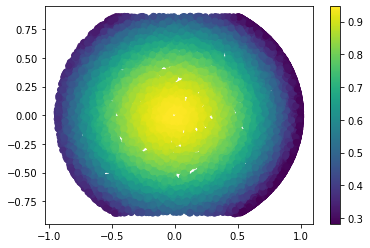

In [12]:
plt.scatter(*bs.skymodel.pos_lmn[:2, :], c=bs.beam_block[:, 1])
plt.colorbar()

In [17]:
%timeit samples = bs.get_gibbs_samples(N_iter=1)

samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
samples shape: (52, 5, 52)
968 ms ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


samples shape: (5200, 5, 52)


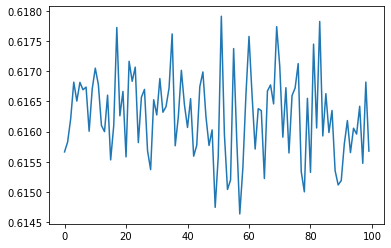

In [18]:
N_run = 10
N_iter = 1e2
samples = bs.get_gibbs_samples(N_iter=N_iter)


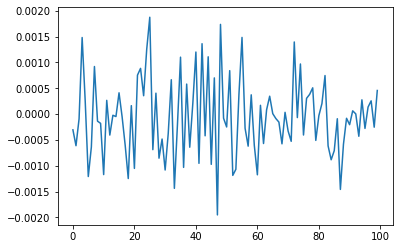

In [19]:
series = np.real(samples[::num_ant, 1, 0])
plt.plot(np.arange(run_iter*N_iter, (run_iter + 1)*N_iter), series)

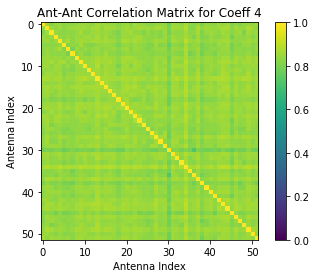

In [24]:
coeff = 4
CC = np.corrcoef(samples[:, coeff, :].T)
plt.imshow(CC.real, vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("Antenna Index")
plt.xlabel("Antenna Index")
plt.title(f"Ant-Ant Correlation Matrix for Coeff {coeff}")
path = "/Users/mike_e_dubs/HERA/beam_gibbs_sampler"
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(f"{path}/corr_coeff_10_ant_param_{coeff}_{num_coeff}_params.png")

In [26]:
num_coeff = 5
num_ant = 10
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)

zernike_matrix shape: (10000, 5)
beam_block_coeffs shape: (5, 10)
beam_block shape: (10000, 10)


samples shape: (100000, 5, 10)


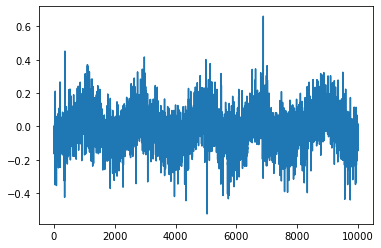

In [30]:

N_iter = 1e4
samples = bs.get_gibbs_samples(N_iter=N_iter)

series = np.real(samples[::num_ant, 1, 0])
plt.plot(np.arange(run_iter*N_iter, (run_iter + 1)*N_iter), series)

zernike_matrix shape: (10000, 5)
beam_block_coeffs shape: (5, 10)
beam_block shape: (10000, 10)
samples shape: (1000000, 5, 10)


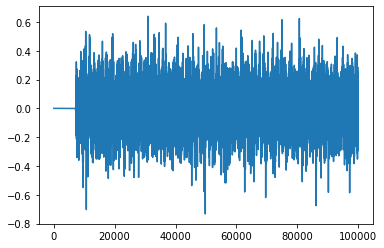

In [34]:
num_coeff = 5
num_ant = 10
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  1e-10 * np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)


N_iter = 1e5
samples = bs.get_gibbs_samples(N_iter=N_iter)

series = np.real(samples[::num_ant, 1, 0])
plt.plot(series)

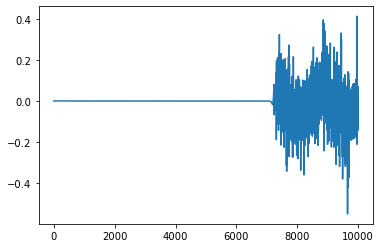

In [58]:
series = np.real(samples[::num_ant, 1, 0][:10000])
plt.plot(series)

In [42]:
np.save("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR.npy", samples)

In [70]:
samples = np.load("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR.npy")

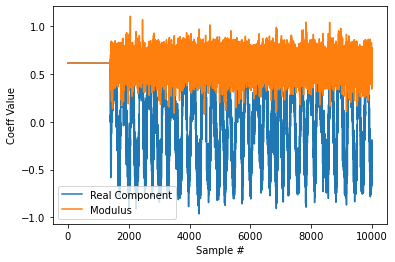

In [58]:
series = samples[::num_ant, 0, 0][:10000]
plt.plot(series.real, label="Real Component")
plt.plot(np.abs(series), label="Modulus")
plt.ylabel("Coeff Value")
plt.xlabel("Sample #")
plt.legend()
plt.savefig("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR_coeff_0_ant_0.png")

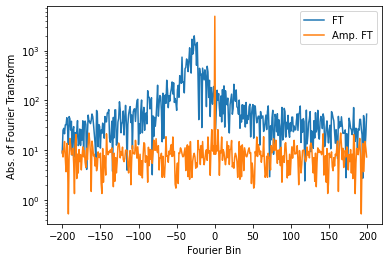

In [60]:
fft_abs = fftshift(np.abs(fft(series[2000:])))
abs_fft = fftshift(np.abs(fft(np.abs(series[2000:]))))

plt.plot(np.arange(400) - 200, fft_abs[3800:4200], label="FT")
plt.plot(np.arange(400) - 200, abs_fft[3800:4200], label="Amp. FT")
plt.legend()
plt.ylabel("Abs. of Fourier Transform")
plt.xlabel("Fourier Bin")
plt.yscale("log")
plt.savefig("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR_coeff_0_ant_0_FT.png")

zernike_matrix shape: (10000, 5)
beam_block_coeffs shape: (5, 20)
beam_block shape: (10000, 20)
samples shape: (2000000, 5, 20)


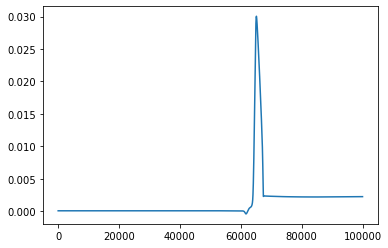

In [61]:
num_coeff = 5
num_ant = 20
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  1e-10 * np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)


N_iter = 1e5
samples = bs.get_gibbs_samples(N_iter=N_iter)

series = np.real(samples[::num_ant, 1, 0])
plt.plot(series)

In [62]:
np.save("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR_20_ant.npy", samples)

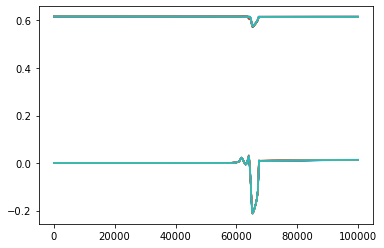

In [76]:
samples = np.load("/Users/mike_e_dubs/HERA/beam_gibbs_sampler/Long_run_samples_high_SNR_20_ant.npy")


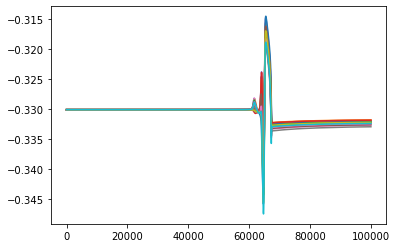

In [80]:
series = samples[::num_ant, 4, :]
plt.plot(series.real)

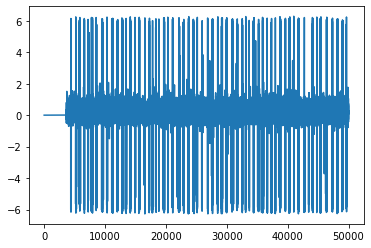

In [74]:
series = samples[::num_ant, 0, :]
plt.plot(np.angle(series[:, 1])  np.angle(series[:, 0]))

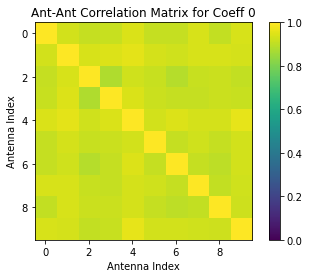

In [60]:
coeff = 0
CC = np.corrcoef(samples[::num_ant, coeff, :][:10000].T)
plt.imshow(CC.real, vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("Antenna Index")
plt.xlabel("Antenna Index")
plt.title(f"Ant-Ant Correlation Matrix for Coeff {coeff}")
path = "/Users/mike_e_dubs/HERA/beam_gibbs_sampler"
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(f"{path}/corr_coeff_10_ant_param_{coeff}_{num_coeff}_params_high_snr.png")

In [201]:

num_coeff = 2
num_ant = 10
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)


prior_mean_block=np.repeat(np.array(beam_coeffs[:num_coeff])[np.newaxis, :],
                           new_uvd.Nants_data, axis=0)
prior_cov_block = 1 * np.vstack(num_ant * [np.eye(num_coeff)])

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  1e-10*np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)



zernike_matrix shape: (100, 2)
beam_block_coeffs shape: (2, 10)
beam_block shape: (100, 10)


samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)
samples shape: (100000, 2, 10)


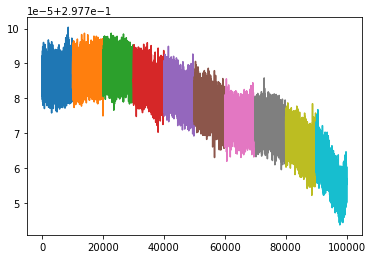

In [202]:
N_run = 10
N_iter = 1e4
for run_iter in range(N_run):
    samples = bs.get_gibbs_samples(N_iter=N_iter)
    series = np.real(samples[::num_ant, 0, 0])
    plt.plot(np.arange(run_iter*N_iter, (run_iter + 1)*N_iter), series)
    del samples

In [76]:
num_coeff = 5
num_ant = 52
new_uvd = uvd.select(antenna_nums=uvd.antenna_numbers[:num_ant], inplace=False)
new_uvd.select(ant_str='cross', inplace=True)


prior_mean_block=np.repeat(np.array(beam_coeffs[:num_coeff])[np.newaxis, :],
                           new_uvd.Nants_data, axis=0)
prior_cov_block = 1 * np.vstack(num_ant * [np.eye(num_coeff)])

bs = beam_sampler(sm, new_uvd, beam_coeffs[:num_coeff],
                  1e-10*np.ones(np.size(new_uvd.data_array)),
                  prior_mean_block=prior_mean_block,
                  prior_cov_block=prior_cov_block)




zernike_matrix shape: (100, 5)
beam_block_coeffs shape: (5, 52)
beam_block shape: (100, 52)


In [35]:
N_iter = 1e4
samples = bs.get_gibbs_samples(N_iter=N_iter)

samples shape: (520000, 5, 52)


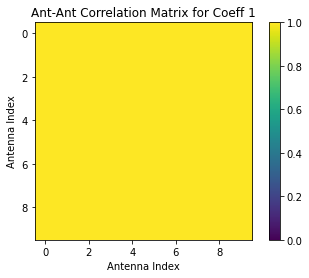

In [44]:
ZCC = np.corrcoef(samples[:, :, 0].T)
print(np.linalg.eig(ZCC))

(array([4.88038580e+00-7.21306263e-19j, 1.18902836e-01-2.19477847e-18j,
       6.31017707e-04-6.68599169e-18j, 6.40394596e-07+1.21327248e-18j,
       7.97035983e-05+8.64630196e-18j]), array([[ 0.45185037+0.00158635j,  0.17003085+0.00933119j,
        -0.42931684+0.00271231j,  0.75605225+0.j        ,
         0.10075432+0.02728426j],
       [-0.45145281+0.00429999j,  0.20847723-0.00630267j,
         0.13612156-0.01799291j,  0.18904323+0.02088692j,
         0.83525024+0.j        ],
       [ 0.45239097+0.j        ,  0.09320952+0.00677205j,
        -0.46696758-0.02898642j, -0.61455711-0.00179447j,
         0.43591959-0.00024329j],
       [-0.43863115+0.01698596j,  0.70732405+0.j        ,
        -0.44131956+0.00582289j, -0.10566319-0.01347986j,
        -0.31741496+0.01055195j],
       [ 0.44119494+0.00205691j,  0.6468075 +0.00994098j,
         0.61897583+0.j        , -0.05550149+0.01004516j,
        -0.01147647-0.02097425j]]))


In [61]:
corr = np.correlate(samples[::num_ant, 0, 0], samples[::num_ant, 0, 0], mode='full')
den_1 = np.arange(1, int(1e4), 1)
den_2 = np.arange(int(1e4), 0, -1)
denom = np.concatenate([den_1, den_2])
corr_ave = corr / np.array(denom)

Casting complex values to real discards the imaginary part


(0.0, 1.0)

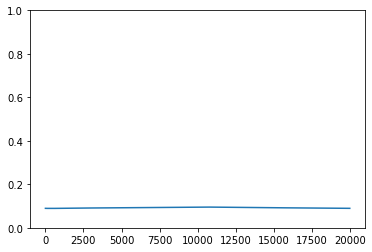

In [70]:
plt.plot(corr_ave)
plt.ylim([0, 1])

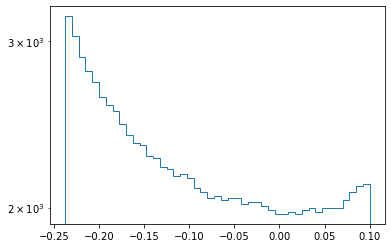

In [179]:

_, _, _ = plt.hist(np.real(samples[:, 0, 0]), bins='auto', histtype='step', log=True)

251.55273610882088


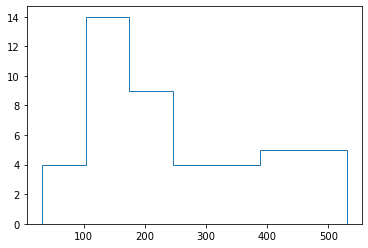

In [20]:
_, _, _ = plt.hist(np.abs(bs.model.flatten()), bins='auto', histtype='step')
print(np.mean(np.abs(bs.model.flatten())))

In [21]:
_, _, _ = plt.hist(np.abs(hera_sim_model.uvdata.data_array.flatten()), bins='auto', histtype='step')

NameError: name 'hera_sim_model' is not defined

In [21]:
%timeit bs.get_gibbs_samples(N_iter=1)

samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
samples shape: (52, 2, 52)
s

In [169]:
mean = np.mean(samples[::10, 0, 1])
series = samples[::10, 0, 0]
corr = np.correlate(series, series, mode='full')

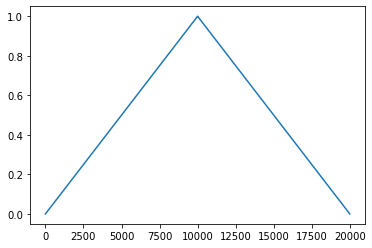

In [165]:
plt.plot(corr.real / np.amax(corr.real))

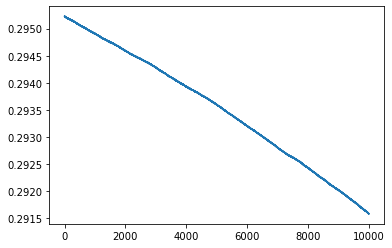

In [166]:
plt.plot(np.real(series))

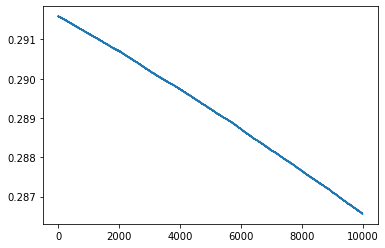

In [170]:
plt.plot(np.real(series))

In [347]:
mean_samp = np.mean(samples, axis=0)
mean_samp.shape

(1, 3)

In [348]:
print(mean_samp)

[[0.00012128-0.00661362j 0.02767323+0.00501539j 0.00944623+0.00113638j]]


In [167]:
np.unique(np.real([sample[0, 0] for sample in samples]))

array([-14886.6463857])

In [172]:
print(np.amin([np.real(sample[0, 0]) for sample in samples]))

12199.55480175167


Casting complex values to real discards the imaginary part


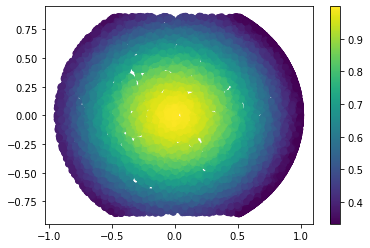